In [1]:
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics       
import os

os.chdir('../../')

In [2]:
label_dict_loc = './label_dict.pkl'
with open(label_dict_loc, 'rb') as f:
    check_dict = pickle.load(f)

meta_df = pd.read_csv('./meta_df.csv')

label2num = check_dict['label2num']
num2label = check_dict['num2label']

labels = label2num.keys()
label_sum_cols = [f'{label}_sum' for label in labels]

# make proportion of its image
for label in label_sum_cols:
    meta_df[f'{label}_prop'] = meta_df[label] / meta_df['area']

label_prop_cols = [i for i in meta_df.columns if i.endswith('_prop')]


In [4]:
trainval_image_locs = meta_df.image_loc
full_images = glob.glob('./VOCdevkit/VOC2012/JPEGImages/*')
remained_images = set(full_images) - set(trainval_image_locs)
print(len(full_images))
print(len(remained_images))

17125
14212


In [5]:
train_df = meta_df[meta_df['ftype'] == 'train']
print(len(train_df))

1464


at K: 2 Silhouette Coefficient (euclidean):0.404
at K: 3 Silhouette Coefficient (euclidean):0.265
at K: 4 Silhouette Coefficient (euclidean):0.256
at K: 5 Silhouette Coefficient (euclidean):0.272
at K: 6 Silhouette Coefficient (euclidean):0.287
at K: 7 Silhouette Coefficient (euclidean):0.298
at K: 8 Silhouette Coefficient (euclidean):0.300
at K: 9 Silhouette Coefficient (euclidean):0.304
at K: 10 Silhouette Coefficient (euclidean):0.320
at K: 11 Silhouette Coefficient (euclidean):0.270
at K: 12 Silhouette Coefficient (euclidean):0.328
at K: 13 Silhouette Coefficient (euclidean):0.307
at K: 14 Silhouette Coefficient (euclidean):0.287
at K: 15 Silhouette Coefficient (euclidean):0.291
at K: 16 Silhouette Coefficient (euclidean):0.307
at K: 17 Silhouette Coefficient (euclidean):0.307
at K: 18 Silhouette Coefficient (euclidean):0.323
at K: 19 Silhouette Coefficient (euclidean):0.319
at K: 20 Silhouette Coefficient (euclidean):0.336
at K: 21 Silhouette Coefficient (euclidean):0.326
at K: 22

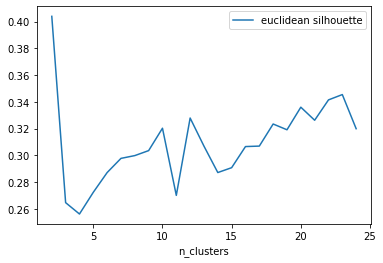

In [6]:
X = train_df[label_prop_cols].values

kmeans_exp_list = []
for cur_num in range(2, 25):
    km = KMeans(n_clusters=cur_num, init='k-means++', n_init=50, max_iter=1000, random_state = 2021)
    km.fit(X)
    euc_silhouette = metrics.silhouette_score(X, km.labels_, metric='euclidean')
    kmeans_exp_list.append([cur_num, euc_silhouette, km])
    print(f"at K: {cur_num} Silhouette Coefficient (euclidean):{euc_silhouette :0.3f}")
    
kmeans_exp_list = np.array(kmeans_exp_list)
cur_df = pd.DataFrame(zip(kmeans_exp_list[:,0], kmeans_exp_list[:,1]), columns=['n_clusters', 'euclidean silhouette'])
ax = cur_df[['euclidean silhouette']].set_index(cur_df.n_clusters).plot()    



In [8]:
X = meta_df[label_prop_cols].values

In [10]:


def apply_cluster(df, num_cluster, kmeans_exp_list):
    
    cur_km = kmeans_exp_list[num_cluster-2][-1]
    df[f'cluster_num_{num_cluster}'] = cur_km.predict(X)
    temp_df = pd.DataFrame(df[f'cluster_num_{num_cluster}']
                 .value_counts()
                 .sort_index())
    display(temp_df)
    cluster_center_df = pd.DataFrame(cur_km.cluster_centers_.T, 
                                     index = labels)
    cluster_center_df = cluster_center_df.T
    cluster_center_df.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.legend(title='labels', bbox_to_anchor=(1.00, 1), loc='upper left')
    return df


,cluster_num_10
0,1233
1,822
2,217
3,97
4,161
5,70
6,34
7,109
8,93
9,77


,cluster_num_22
0,714
1,38
2,100
3,213
4,98
5,78
6,48
7,25
8,83
9,34


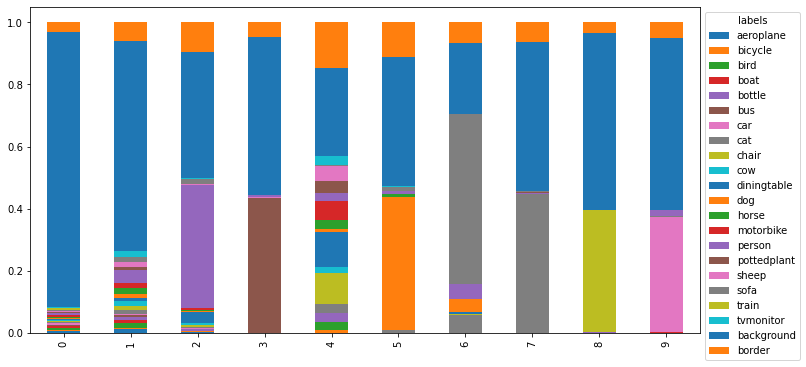

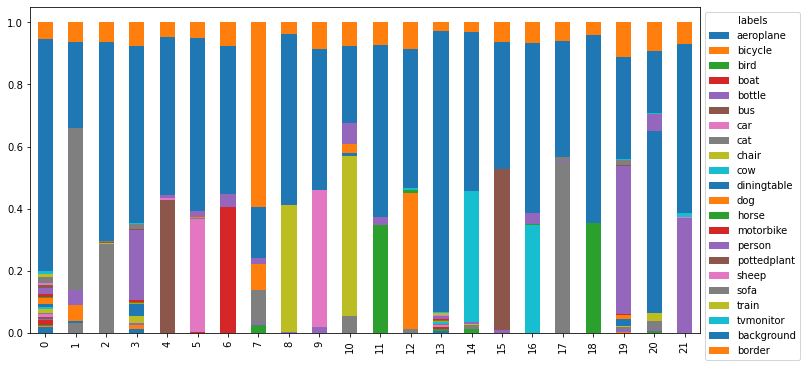

In [11]:
meta_df = apply_cluster(meta_df, 10, kmeans_exp_list)
meta_df = apply_cluster(meta_df, 22, kmeans_exp_list)

In [16]:
meta_df.columns


Index(['id', 'ftype', 'image_loc', 'mask_loc', 'height', 'width', 'area',
       'aeroplane_sum', 'bicycle_sum', 'bird_sum', 'boat_sum', 'bottle_sum',
       'bus_sum', 'car_sum', 'cat_sum', 'chair_sum', 'cow_sum',
       'diningtable_sum', 'dog_sum', 'horse_sum', 'motorbike_sum',
       'person_sum', 'pottedplant_sum', 'sheep_sum', 'sofa_sum', 'train_sum',
       'tvmonitor_sum', 'background_sum', 'border_sum', 'aeroplane_sum_prop',
       'bicycle_sum_prop', 'bird_sum_prop', 'boat_sum_prop', 'bottle_sum_prop',
       'bus_sum_prop', 'car_sum_prop', 'cat_sum_prop', 'chair_sum_prop',
       'cow_sum_prop', 'diningtable_sum_prop', 'dog_sum_prop',
       'horse_sum_prop', 'motorbike_sum_prop', 'person_sum_prop',
       'pottedplant_sum_prop', 'sheep_sum_prop', 'sofa_sum_prop',
       'train_sum_prop', 'tvmonitor_sum_prop', 'background_sum_prop',
       'border_sum_prop', 'cluster_num_10', 'cluster_num_22'],
      dtype='object')

In [52]:
train_vc = pd.DataFrame(meta_df[meta_df.ftype == 'train'].cluster_num_10.value_counts()).reset_index()
test_vc = pd.DataFrame(meta_df[meta_df.ftype == 'test'].cluster_num_10.value_counts()).reset_index()

train_vc.columns = ['cluster_num_10','train_cnt']
test_vc.columns = ['cluster_num_10','test_cnt']
pd.merge(train_vc, test_vc, on='cluster_num_10').sort_values('cluster_num_10')


,cluster_num_10,train_cnt,test_cnt
0,0,624,609
1,1,421,401
2,2,100,117
5,3,49,48
3,4,84,77
8,5,30,40
9,6,17,17
4,7,58,51
6,8,44,49
7,9,37,40


In [53]:
train_vc = pd.DataFrame(meta_df[meta_df.ftype == 'train'].cluster_num_22.value_counts()).reset_index()
test_vc = pd.DataFrame(meta_df[meta_df.ftype == 'test'].cluster_num_22.value_counts()).reset_index()

train_vc.columns = ['cluster_num_22','train_cnt']
test_vc.columns = ['cluster_num_22','test_cnt']
pd.merge(train_vc, test_vc, on='cluster_num_22').sort_values('cluster_num_22')


,cluster_num_22,train_cnt,test_cnt
1,0,362,352
14,1,19,19
5,2,47,53
2,3,97,116
4,4,50,48
7,5,38,40
10,6,25,23
20,7,12,13
6,8,40,43
15,9,18,16



- Person: person
- Animal: bird, cat, cow, dog, horse, sheep
- Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
- Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

In [54]:
meta_df.to_csv('./meta_df_w_prop.csv')